# CS4200/5200_SP24_Uninformed Search Implementation in Python

## Jacob R Lebold

To start, we will import all the given modules to help our program run.

In [1]:
from search import *
from collections import deque
from notebook import psource, heatmap, guassian_kernal, show_map, final_path_colors, display_visual, plot_NQueens

#used in demo, hides warnings in matplotlib section, not sure if will be needed for assignment
import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'qpsolvers'

We can also implement the visualization libaries to display our graphs and results

In [4]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import lines

from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display
import time

## Problem Class

As shown in the demo, we will implement the abstract Problem class

In [5]:
class Problem:
    def __init__(self, initial, goal = None):
        self.initial = initial
        self.goal = goal
        
    def actions(self, state):
        raise NotImplementedError
    
    def result(self, state, action):
        raise NotImplementedError
        
    def goal_test(self, state):
        #return true if the state is the goal
        if isinstance(self.goal, list):
            return is_in(state, self.goal)
        else:
            return state == self.goal
        
    def path_cost(self, c, state1, action, state2):
        return c + 1
    
    def value(self, state):
        raise NotImplementedError

## Node Class

We will also need to implement the abstract Node class that defines our nodes within the graph.

In [6]:
class Node:
    def __init__(self, state, parent = None, action = None, path_cost = 0):
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.depth = 0
        if parent:
            self.depth = parent.depth + 1
            
    def __repr__(self):
        return "<Node {}>".format(self.state)
    
    def __lt__(self, node):
        return self.state < node.state
    
    def expand(self, problem):
        #lists the nodes reachable in one hop from current node
        return [self.child_node(problem, action)
                for action in problem.actions(self.state)]
    
    def child_node(self, problem, action):
        next_state = problem.result(self.state, action)
        next_node = Node(next_state, self, action, problem.path_cost(self.path_cost, self.state, action, next_state))
        return next_node
    
    def solution(self):
        #returns the sequence of actions from root node to this node
        return [node.action for node in self.path()[1:]]
    
    def path(self):
        #returns list of nodes that form the path from root to this node
        node, path_back = self, []
        while node:
            path_back.append(node)
            node = node.parent
        return list(reversed(path_back))
    
    def __eq__(self, other):
        return isinstance(other, Node) and self.state == other.state
    
    def __hash__(self):
        return hash(self.state)

Using the abstract class Problem, we will define our real problem named GraphProblem

In [7]:
class GraphProblem(Problem):
    def __init__(self, initial, goal, graph):
        super().__init__(initial, goal)
        self.graph = graph
        
    def actions(self, A):
        #actions at a graph node are its neighbors
        return list(self.graph.get(A).keys())
    
    def result(self, state, action):
        #result of going to neighbor is just that neighbor
        return action
    
    def path_cost(self, cost_so_far, A, action, B):
        return cost_so_far + (self.graph.get(A, B) or np.inf)
    
    def find_min_edge(self):
        #find minimum value of edges
        m = np.inf
        for d in self.graph.graph_dict.values():
            local_min = min(d.values())
            m = min(m, local_min)
            
        return m
    
    def h(self, node):
        #function is straight line distance from a nodes state to goal
        locs = getattr(self.graph, 'locations', None)
        if locs:
            if type(node) is str:
                return int(distance(locs[node], locs[self.goal]))
            
            return int(distance(locas[node.state], locs[self.goal]))
        else:
            return np.inf
    

Now we need to implement a Graph class that will connect our nodes together and set their distances from each other

In [8]:
class Graph:
    def __init__(self, graph_dict = None, directed = True):
        self.graph_dict = graph_dict or {}
        self.directed = directed
        if not directed:
            self.make_undirected()
            
    def make_undirected(self):
        #make a directed graph into an undirected graph my adding edges
        for a in list(self.graph_dict.keys()):
            for (b, dict) in self.graph_dict[a].items():
                self.connect1(b, a, dist)
                
    def connect(self, A, B, distance = 1):
        #add a link between A and B
        self.connect1(A, B, distance)
        if not self.directed:
            self.connect1(B, A, distance)
            
    def connect1(self, A, B, distance):
        #add a link between two nodes in one direction only
        self.graph_dict.setdefault(A, {})[B] = distance
        
    def get(self, a, b = None):
        #return link distance or a dict of node: distance entries
        links = self.graph_dict.setdefault(a, {})
        if b is None:
            return links
        else: 
            return links.get(b)
        
    def nodes(self):
        #return a list of the nodes in a graph
        s1 = set([k for k in self.graph_dict.keys()])
        s2 = set([k2 for v in self.graph_dict.values() for k2, v2 in v.items()])
        nodes = s1.union(s2)
        return list(nodes)
    
    def UndirectedGraph(graph_dict = None):
        #build an undirected graph
        return Graph(graph_dict = graph_dict, directed = False)

In [9]:
#this defines the nodes in the graph and what nodes they are connected to, along with the distances from each node
assignment_graph = UndirectedGraph(dict(
    start = dict(A = 2, B = 3, D = 5), 
    A = dict(C = 4), 
    B = dict(D = 4), 
    C = dict(goal = 2, D = 1), 
    D = dict(goal = 5), 
    goal = dict(C = 2, D = 5)))

#these locations are just plots on a 2d plane for the visualization of the graph
assignment_graph.locations = dict(
    start = (50, 250), A = (100, 350), B = (75, 150), C = (150, 300), 
    D = (200, 150), goal = (250, 350))

Now that we have everything for the graph defined, lets set the locations of each node for our visualization

In [10]:
graph_locations = assignment_graph.locations
print(graph_locations)

{'start': (50, 250), 'A': (100, 350), 'B': (75, 150), 'C': (150, 300), 'D': (200, 150), 'goal': (250, 350)}


Now we can initialize an empty graph, adding nodes and their edges and place their location on the map

In [11]:
def show_map(graph_data, node_colors=None):
    G = nx.Graph(graph_data['graph_dict'])
    node_colors = node_colors or graph_data['node_colors']
    node_positions = graph_data['node_positions']
    node_label_pos = graph_data['node_label_positions']
    edge_weights = graph_data['edge_weights']

    # set the size of the plot
    plt.figure(figsize=(18, 13))
    # draw the graph (both nodes and edges) with locations from romania_locations
    nx.draw(G, pos={k: node_positions[k] for k in G.nodes()},
            node_color=[node_colors[node] for node in G.nodes()], linewidths=0.3, edgecolors='k')

    # draw labels for nodes
    node_label_handles = nx.draw_networkx_labels(G, pos=node_label_pos, font_size=14)

    # add a white bounding box behind the node labels
    [label.set_bbox(dict(facecolor='white', edgecolor='none')) for label in node_label_handles.values()]

    # add edge lables to the graph
    nx.draw_networkx_edge_labels(G, pos=node_positions, edge_labels=edge_weights, font_size=14)

    # add a legend
    white_circle = lines.Line2D([], [], color="white", marker='o', markersize=15, markerfacecolor="white")
    orange_circle = lines.Line2D([], [], color="orange", marker='o', markersize=15, markerfacecolor="orange")
    red_circle = lines.Line2D([], [], color="red", marker='o', markersize=15, markerfacecolor="red")
    gray_circle = lines.Line2D([], [], color="gray", marker='o', markersize=15, markerfacecolor="gray")
    green_circle = lines.Line2D([], [], color="green", marker='o', markersize=15, markerfacecolor="green")
    plt.legend((white_circle, orange_circle, red_circle, gray_circle, green_circle),
               ('Un-explored', 'Frontier', 'Currently Exploring', 'Explored', 'Final Solution'),
               numpoints=1, prop={'size': 16}, loc=(.8, .75))

    # show the plot. No need to use in notebooks. nx.draw will show the graph itself.
    plt.show()

In [12]:
#node colors, node positions, and node label positions
node_colors = {node: 'white' for node in assignment_graph.locations.keys()}
node_positions = assignment_graph.locations
node_label_pos = { k:[v[0], v[1]-10] for k, v in assignment_graph.locations.items()}
edge_weights = {(k, k2) : v2 for k, v in assignment_graph.graph_dict.items() for k2, v2 in v.items()}

assignment_graph_data = { 'graph_dict' : assignment_graph.graph_dict, 
                          'node_colors': node_colors,
                          'node_positions': node_positions,
                          'node_label_positions': node_label_pos, 
                          'edge_weights': edge_weights
                        }

We have now built the assignment graph and now we can display it in our notebook

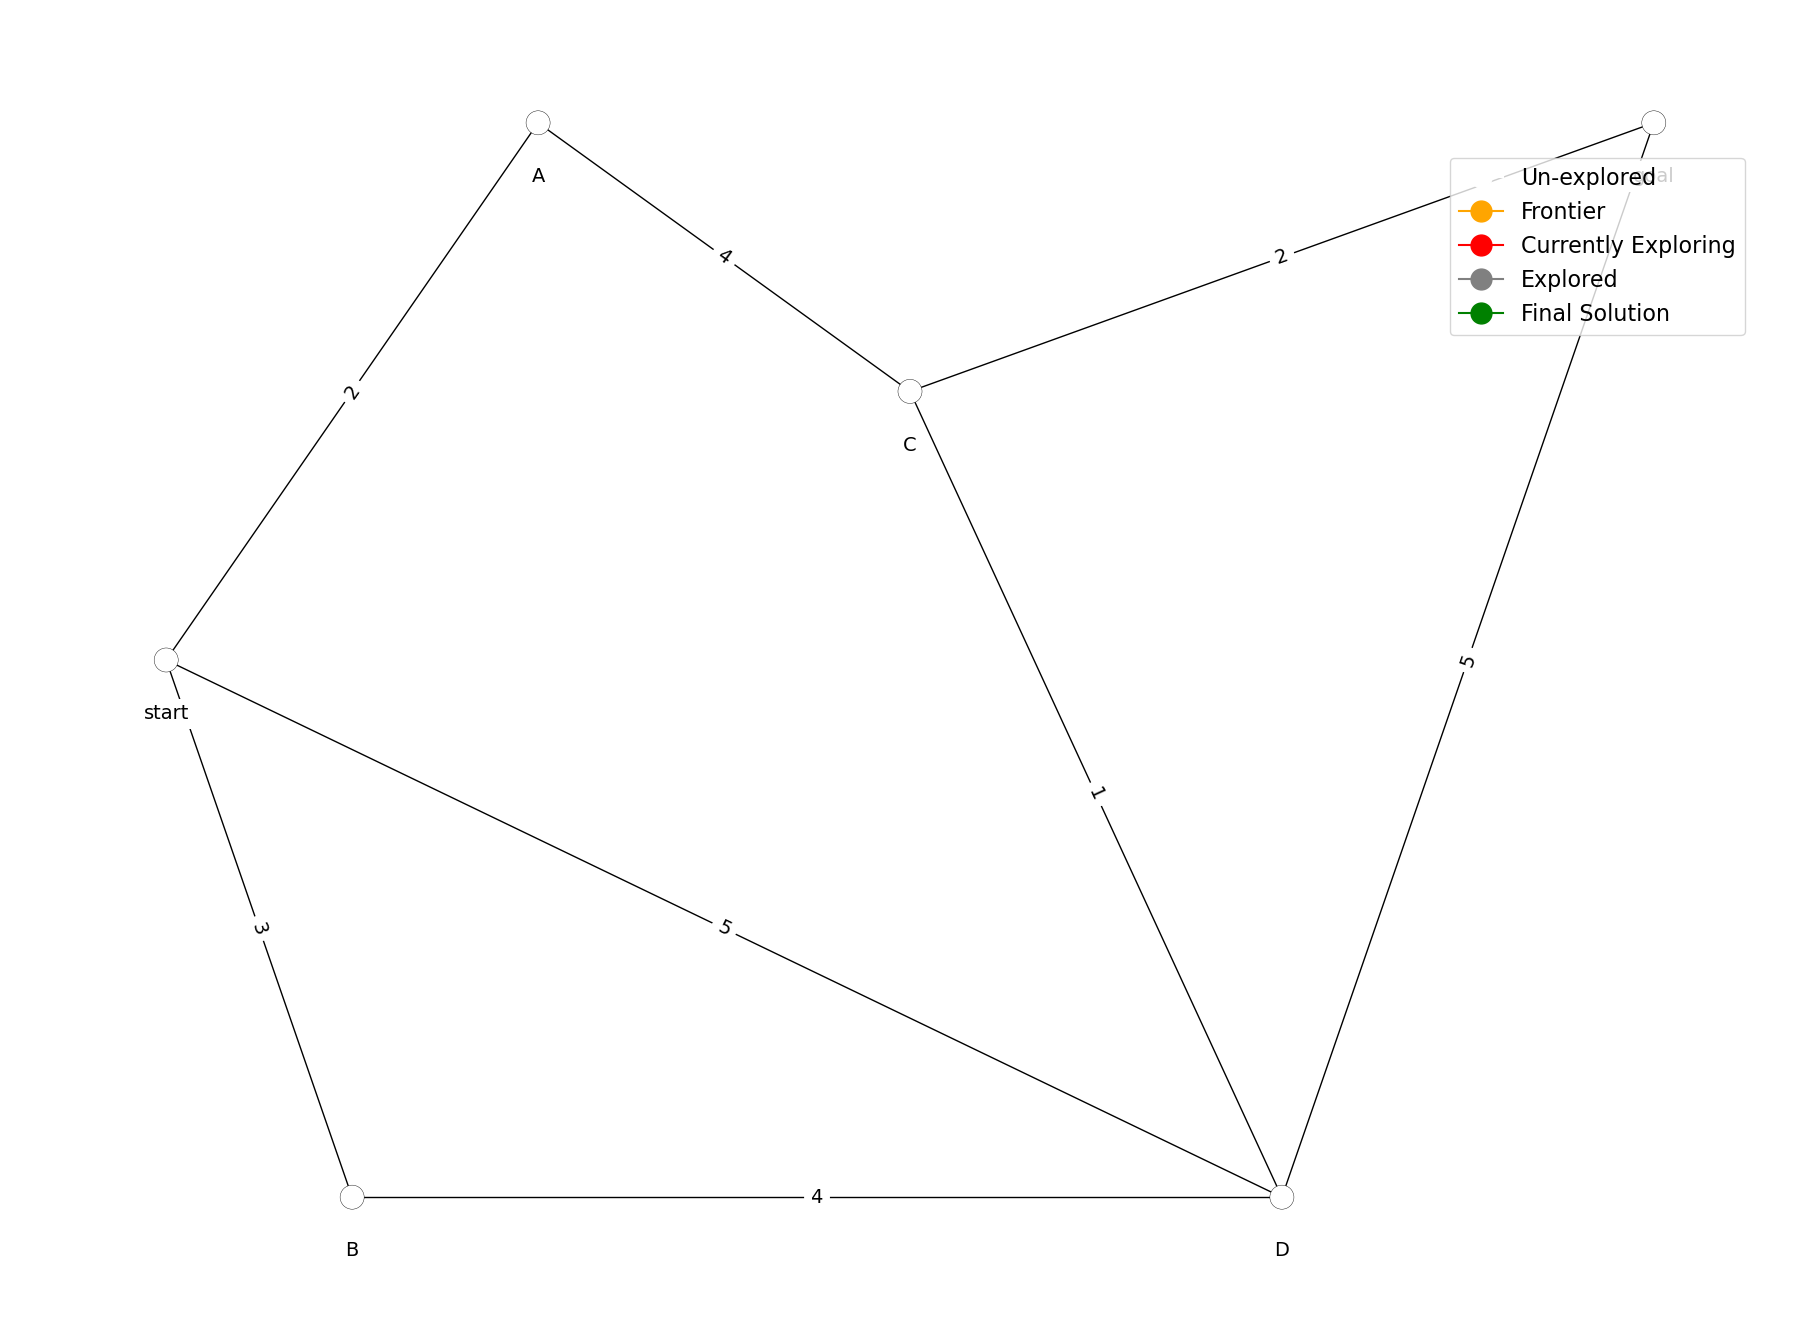

In [13]:
show_map(assignment_graph_data)

## Breadth-first tree search 

The first search algorithm we will use will be Breadth-first tree search. 

In [14]:
#code for Breadth-first tree search
def breadth_first_tree_search(problem):
    #frontier is a FIFO queue, we want to deque the start node to begin search
    frontier = deque([Node(problem.initial)])
    
    #while the frontier contains nodes
    while frontier:
        node = frontier.popleft() #pop the first node in the queue
        if problem.goal_test(node.state): #if the node that was popped is the goal
            return node #return the goal node
        frontier.extend(node.expand(problem)) #if not goal, continue expanding the search to the nodes neighbors
    return None


In [15]:
assignment_problem = GraphProblem('start', 'goal', assignment_graph)
result = breadth_first_tree_search(assignment_problem)
result.solution()

['D', 'goal']

## Breadth-first Graph Search

We can search this graph using Breadth-first Graph Search as well. Although the solution path should be the same as Breadth-first Tree Search, as the goal from node "D" is only 1 hop away, compared to two hops away from nodes "A" and "B", meaning that once D gets explored, in either algorithm, the path that it finds is closest is ["D", "goal"]

In [16]:
def breadth_first_graph_search(problem):
    #set the initial node to our start node
    node = Node(problem.initial)
    #test that node to see if it is our goal
    if problem.goal_test(node.state):
        return node #return the node as it is our goal, no steps needed to be taken in search
    
    #deque the node if not goal so we can begin searching its neighbors
    frontier = deque([node])
    explored = set() #in graph search, we do not want to search any repeating nodes
    
    #while the frontier contains nodes to search
    while frontier:
        node = frontier.popleft() #pop the first node in queue
        explored.add(node.state) #add that node so we know not to explore it again
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier: #double checking that node has not be explored already
                if problem.goal_test(child.state): #run a goal test to check node before appending
                    return child
                frontier.append(child)
    return None
        

In [17]:
#run our problem to output the solution path
assignment_problem = GraphProblem("start", "goal", assignment_graph)
result = breadth_first_graph_search(assignment_problem)
result.solution()

['D', 'goal']

## Depth-first Tree Search

Depth-first Tree Search will search the deepest nodes in the search tree first unlike depth-first where we search the shallowest nodes. If there is a closed loop however, we could run into an infinite loop.

In [ ]:
def depth_first_tree_search(problem):
    
    #set the initial node into the frontier (stack)
    frontier = [Node(problem.initial)]
    
    #while the frontier has nodes to explore
    while frontier:
        node = frontier.pop()
        if problem.goal_test(node.state): #check if the node is our goal node
            return node
        frontier.extend(node.expand(problem))
    return None


In [ ]:
assignment_problem = GraphProblem("start", "goal", assignment_graph)
result = depth_first_tree_search(assignment_problem)
result.solution()

### Depth-first Tree search will run into an infinite loop since the graph is undirected, making the search tree infinitly long (this means this search is incomplete. 

# Depth-First Graph Search

Depth-first Graph Search will allow us to avoid the problem we run into with tree search, as we can keep track of what nodes we have explored, so we will not run into an infinite loop!

In [25]:
def depth_first_graph_search(problem):
    
    #initialize the frontier with the start node
    frontier = [(Node(problem.initial))] #still using LIFO queue
    
    #set an explored set, to help avoid infinite loops 
    explored = set()
    
    #while there are nodes to explore in the frontier
    while frontier: 
        node = frontier.pop()
        if problem.goal_test(node.state): #check if current node is goal node
            return node
        explored.add(node.state) #so we don't search this node again
        frontier.extend(child for child in node.expand(problem)
                        if child.state not in explored and child not in frontier) #if the child node has not already been explored, or in line to be explored
    return None


In [26]:
assignment_problem = GraphProblem("start", "goal", assignment_graph)
result = depth_first_graph_search(assignment_problem)
result.solution()

['D', 'goal']

The Reason we get a solution path of ['D', 'goal'] has to do with how the children nodes of "start" are being put onto the stack. In a perfect scenario, node "B" would be on top of the stack, and exploring that node would give us a solution path of ['B', 'D', 'goal'] but instead node D ends up on top of the stack, the algorithm finds that path to goal first and goes with it. The path to the goal could change based on what order the children nodes of 'start' are entered into the stack. 

# Iterative Deepening Search

We have been given the demo code for Depth-limited search, and we need to convert that into Iterative Deepening Search. We will still use the function given in the demo, but we need to create another function. This function will allow us to iterate up to a certain point (we will iterate 20 times), increasing the depth of the Depth-limited search each run through.

In [100]:
#demo code given
def depth_limited_search(problem, limit): #the limit does not need to be at 3 for Iterative deepening, as our other function will set the limit for us
    def recursive_dls(node, problem, limit):
        if problem.goal_test(node.state): #test if given node is our goal 
            return node
        elif limit == 0: #we can stop searching as we have gone through everything (this is our base case for the recursion)
            return 'cutoff' 
        else:
            cutoff_occurred = False #we are not at the limit for our search
            
            #expand the node and recursively check its children nodes
            for child in node.expand(problem):
                result = recursive_dls(child, problem, limit - 1)
                if result == 'cutoff':
                    cutoff_occurred = True
                elif result is not None:
                    return result
            return 'cutoff' if cutoff_occurred else None #if a child resulted in a cutoff, it will return cutoff
        
    #body of depth limited search
    return recursive_dls(Node(problem.initial), problem, limit)

#Now we need to define a function that will let us increase the depth of 
#DLS by 1 every iteration until a solution is found
def iterative_deepening(problem, maximum_depth = 20):
    for limit in range(1, maximum_depth + 1): #iterate through, increasing the limit that our DLS function can search by 1
        result = depth_limited_search(problem, limit)
        
        #return the solution if found
        if result != 'cutoff':
            return result
        
    print("No solution found at set maximum depth") #we need to print since .solution() will not return a string
    return None

In [101]:
#run the iterative deepening function 
assignment_problem = GraphProblem("start", "goal", assignment_graph)
result = iterative_deepening(assignment_problem)
result.solution()

['D', 'goal']

just to make sure we have implemented this correctly, lets try a depth limit of 1, where we should get no solution found 

In [42]:
result = iterative_deepening(assignment_problem, 1)
result.solution()

No solution found at set maximum depth


AttributeError: 'NoneType' object has no attribute 'solution'

Sorry about the error there, not sure how to get rid of it without messing up a lot of code already given to us. The output of "no solution found" stil runs when the maximum depth isn't deep enough to find a solution!!!

# Uniform Cost Search

We can use the demo code for Best-first search to help us in writing a Uniform cost search algorithm. The big difference between the two is how we choose to expand nodes. In BFS, we use an estimate of the cost from the current node to the goal, while in UCS we use the actual cost of the path from start to current node, expanding the nodes with the lowest cumulative cost.  

In [102]:
#UCS function is similar to BestFS, with a change in how we explore the nodes in the priority queue
def uniform_cost_search(problem, f, display = False):
    f = path_cost #set our f variable to path cost, by using the path cost to the current node, we turn BestFS into uniform cost search
    f = memoize(f, 'f')
    #set the start node
    node = Node(problem.initial)
    frontier = PriorityQueue('min', f) #check the path cost of the current node instead of using a heuristic function
    frontier.append(node)
    
    #explore set() so we don't go over the same node more than once
    explored = set()
    
    #while there are nodes in the frontier to check
    while frontier:
        node = frontier.pop()
        if problem.goal_test(node.state): #check if current node is our goal node
            if display:
                print(len(explored), "paths have been expanded and", len(frontier), "paths remain in the frontier")
            return node
        explored.add(node.state) #add current node to set so we don't check it more than once
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                frontier.append(child)
            elif child in frontier:
                if f(child) < frontier[child]: #again, we want to order the frontier based on path_cost instead of a heuristic function
                    del frontier[child]
                    frontier.append(child)
    return None
                
    

In [103]:
#run the UCS function
assignment_problem = GraphProblem("start", "goal", assignment_graph)
result = uniform_cost_search(assignment_problem, path_cost(Node(assignment_problem.initial)))
result.solution()

['A', 'C', 'goal']